# Wine Classification with Random Forest
This notebook trains a Random Forest classifier on the wine dataset and explores feature importance for feature selection.

In [1]:
import sys
from pathlib import Path
# Ensure project root is in the Python path for module resolution
project_root = str(Path.cwd().parent)
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from src.data.load_wine import get_wine_data

In [3]:
# Load the wine dataset
df_X, df_y = get_wine_data(as_frame=True)
df = df_X.copy()
df['target'] = df_y

X = df_X
y = df_y

## Train/Test Split

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Train Random Forest Classifier

In [5]:
# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluate Model Performance

In [6]:
# Predict and evaluate
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



## Feature Importance
Let's visualize the feature importances from the trained Random Forest.

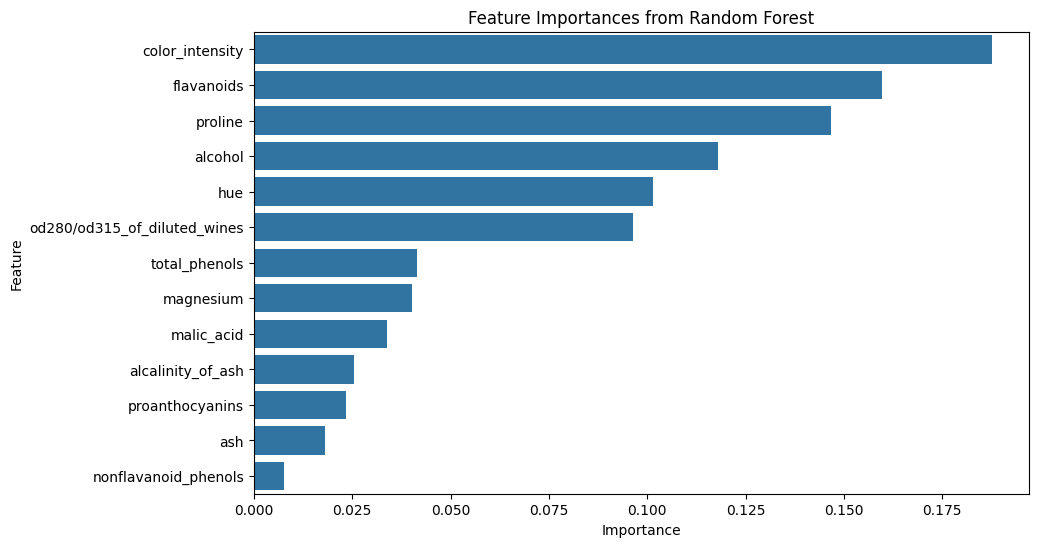

In [7]:
# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices], orient='h')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Select Top Features
Select the top N features based on importance for potential feature selection.

In [8]:
# Select top 5 features
N = 5
top_features = features[indices][:N]
print(f"Top {N} features:", list(top_features))

Top 5 features: ['color_intensity', 'flavanoids', 'proline', 'alcohol', 'hue']


## ROC Curve and Additional Metrics
Let's plot the ROC curve and calculate AUC for each class, as well as show a confusion matrix.

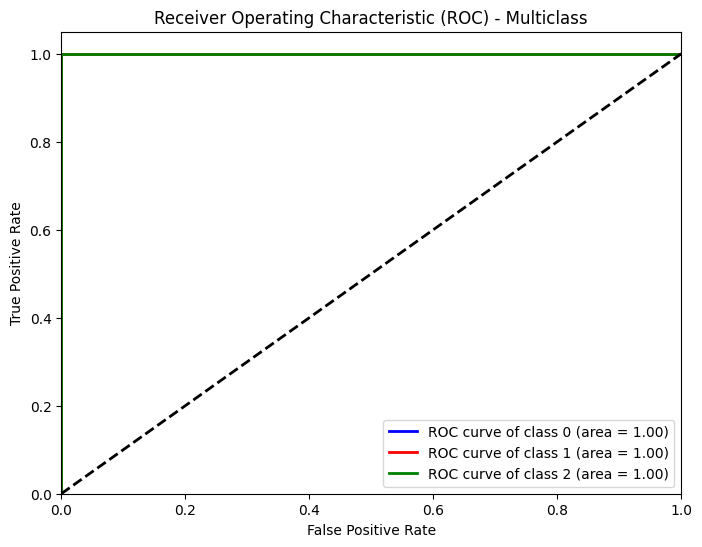

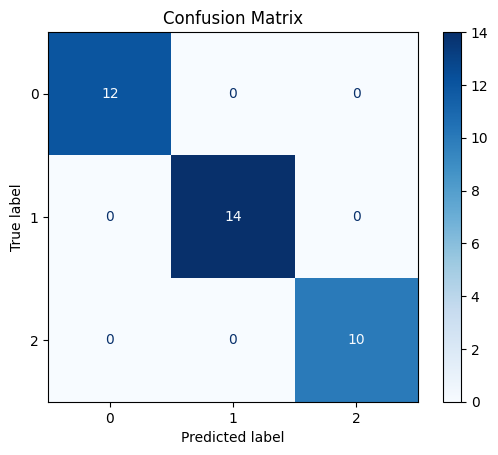

Macro-average AUC: 1.0
Weighted-average AUC: 1.0


In [9]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

# Binarize the output for multiclass ROC
n_classes = len(np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = rf.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc='lower right')
plt.show()

# Show confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Show macro and weighted AUC
print('Macro-average AUC:', roc_auc_score(y_test_bin, y_score, average='macro'))
print('Weighted-average AUC:', roc_auc_score(y_test_bin, y_score, average='weighted'))

## Confusion Matrix Visualization
Visualize the confusion matrix to better understand the classifier's performance across classes.

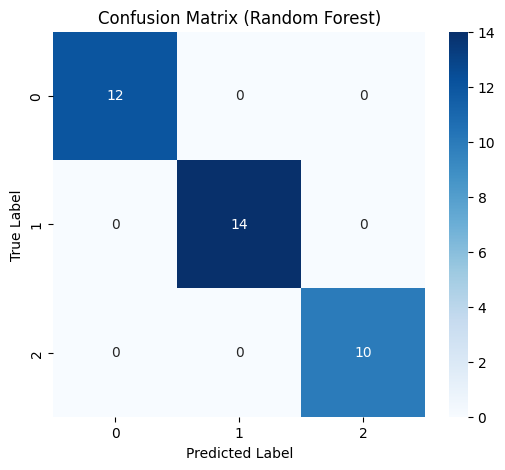

In [10]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

## Addressing Overfitting
The Random Forest model may be overfitting. We'll address this by:
- Limiting tree depth and increasing minimum samples per split/leaf
- Using only the top features
- Using cross-validation to tune hyperparameters and evaluate performance.

In [11]:
# Use only the top N features for training
N = 5  # You can adjust this number
X_selected = X[top_features]

# Split the data again with selected features
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)


In [12]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_cv = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_cv, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_sel, y_train_sel)

print('Best parameters:', grid_search.best_params_)
print('Best cross-validation accuracy:', grid_search.best_score_)


Best parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.97192118226601


In [13]:
# Train and evaluate the best model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_sel, y_train_sel)
y_pred_sel = best_rf.predict(X_test_sel)

print('Test Accuracy (selected features & tuned hyperparameters):', accuracy_score(y_test_sel, y_pred_sel))
print('\nClassification Report:\n', classification_report(y_test_sel, y_pred_sel))


Test Accuracy (selected features & tuned hyperparameters): 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



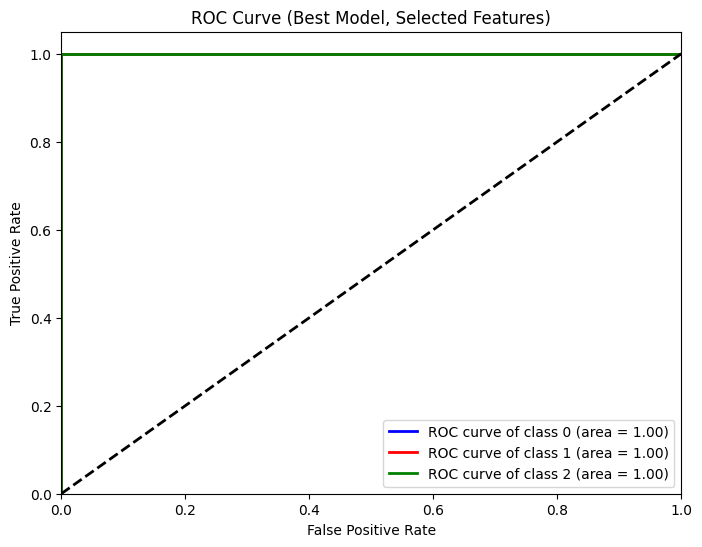

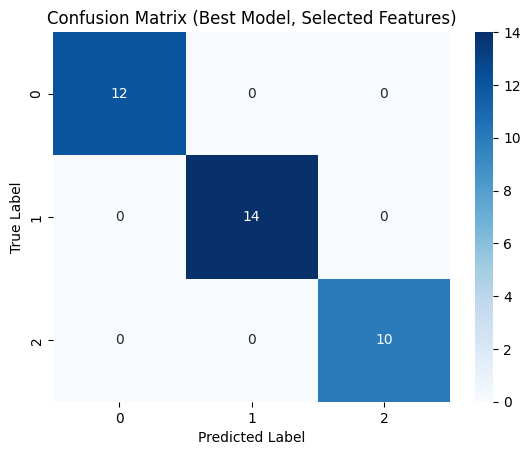

Macro-average AUC: 1.0
Weighted-average AUC: 1.0


In [14]:
# ROC curve and confusion matrix for the best model
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

n_classes = len(np.unique(y))
y_test_sel_bin = label_binarize(y_test_sel, classes=np.unique(y))
y_score_sel = best_rf.predict_proba(X_test_sel)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sel_bin[:, i], y_score_sel[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Best Model, Selected Features)')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix
cm_sel = confusion_matrix(y_test_sel, y_pred_sel)
sns.heatmap(cm_sel, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Best Model, Selected Features)')
plt.show()

# Macro and weighted AUC
print('Macro-average AUC:', roc_auc_score(y_test_sel_bin, y_score_sel, average='macro'))
print('Weighted-average AUC:', roc_auc_score(y_test_sel_bin, y_score_sel, average='weighted'))